# Import Library

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

# Data Visualization

In [2]:
train = list(os.walk('C:\\Users\\LENOVO\\Documents\\Machine Learning Deteksi Tanah\\Training'))

In [3]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'Black Soil': 0, 'Cinder Soil': 1, 'Laterite Soil': 2, 'Peat Soil': 3, 'Yellow Soil': 4}


In [4]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('C:\\Users\\LENOVO\\Documents\\Machine Learning Deteksi Tanah\\Training')
images, labels = shuffle(images, labels)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:18<00:00, 15.76s/it]


In [5]:
images.shape

(400, 150, 150, 3)

## This barplot shows the number of images of each species

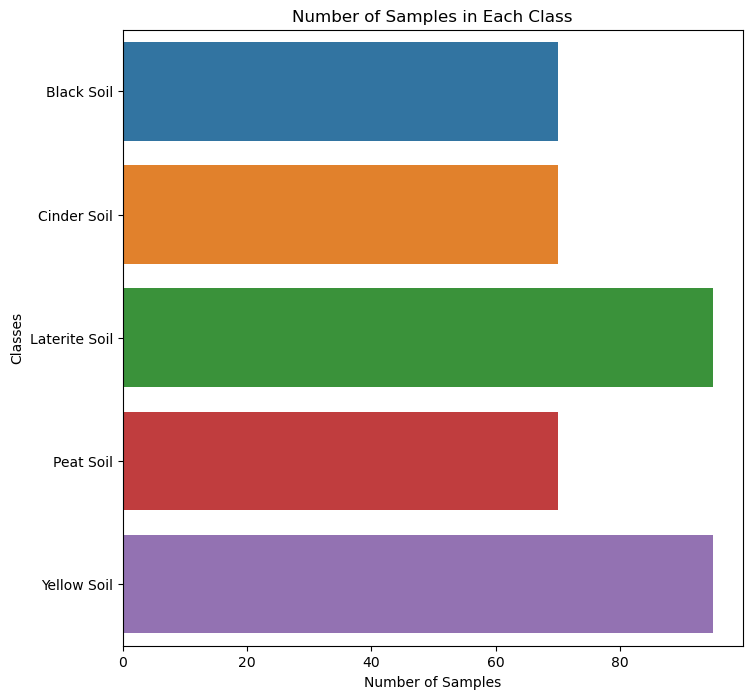

In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path ke folder training
train_folder = 'C:\\Users\\LENOVO\\Documents\\Machine Learning Deteksi Tanah\\Training'

# Ambil nama subfolder (kelas) di dalam folder training
classes = os.listdir(train_folder)

# Inisialisasi list untuk menyimpan jumlah data tiap kelas
no_of_samples = []

# Loop untuk setiap kelas
for cls in classes:
    # Path ke setiap subfolder (kelas)
    cls_folder = os.path.join(train_folder, cls)
    
    # Hitung jumlah file (data) di dalam subfolder (kelas)
    num_files = len(os.listdir(cls_folder))
    
    # Simpan jumlah data ke dalam list
    no_of_samples.append(num_files)

# Plot barplot
plt.figure(figsize=(8, 8))
sns.barplot(y=classes, x=no_of_samples)
plt.xlabel('Number of Samples')
plt.ylabel('Classes')
plt.title('Number of Samples in Each Class')
plt.show()


## Sample images

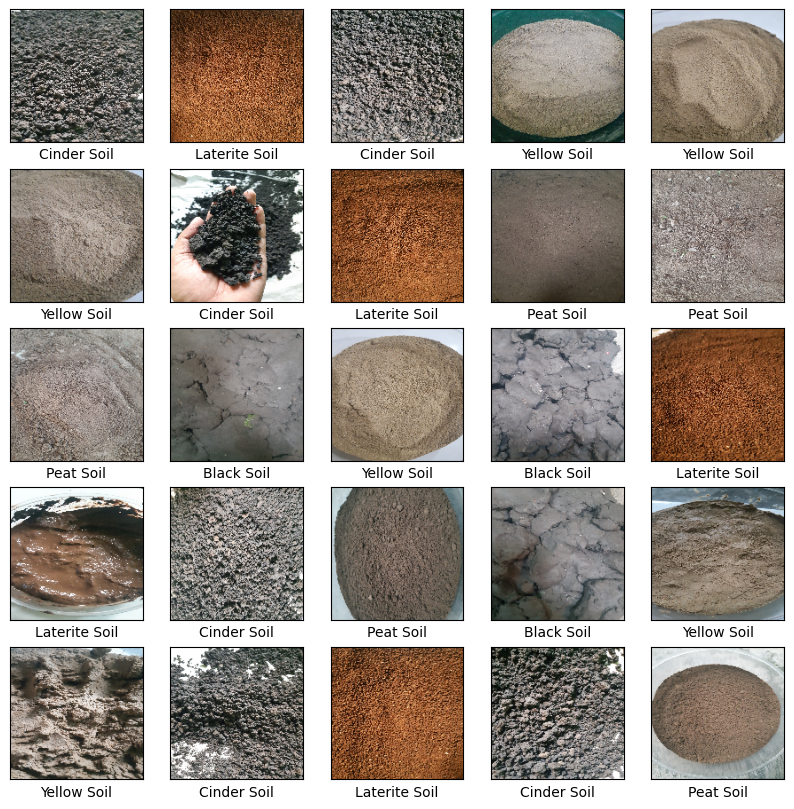

In [7]:
plt.figure(figsize = (10,10))
for _ in range(25):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

# Load images using ImageDatagenerator

In [8]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

In [9]:
train_ds = train_datagen.flow_from_directory('C:\\Users\\LENOVO\\Documents\\Machine Learning Deteksi Tanah\\Training',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('C:\\Users\\LENOVO\\Documents\\Machine Learning Deteksi Tanah\\Training',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 320 images belonging to 5 classes.
Found 80 images belonging to 5 classes.


In [10]:
train_ds.class_indices

{'Black Soil': 0,
 'Cinder Soil': 1,
 'Laterite Soil': 2,
 'Peat Soil': 3,
 'Yellow Soil': 4}

### Some augmented images

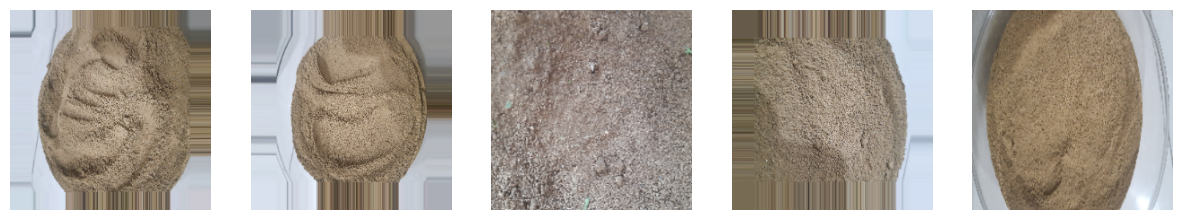

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# Transfer learning

### Xception

In [12]:
from tensorflow.keras.applications import Xception

xcep_base = Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
xcep_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = xcep_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation = 'softmax')(x)
xcep_model = Model(inputs, outputs)

In [13]:
xcep_model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [14]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epochs = 25
xcep_model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/25


C:\Users\LENOVO\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 90s 19s/step - loss: 1.5153 - categorical_accuracy: 0.3313 - val_loss: 1.3156 - val_categorical_accuracy: 0.5750
Epoch 2/25
5/5 [==============================] - 77s 16s/step - loss: 1.2252 - categorical_accuracy: 0.5750 - val_loss: 1.1608 - val_categorical_accuracy: 0.7000
Epoch 3/25
5/5 [==============================] - 77s 16s/step - loss: 1.0345 - categorical_accuracy: 0.7063 - val_loss: 1.0108 - val_categorical_accuracy: 0.8000
Epoch 4/25
5/5 [==============================] - 77s 16s/step - loss: 0.8350 - categorical_accuracy: 0.8156 - val_loss: 0.8160 - val_categorical_accuracy: 0.8125
Epoch 5/25
5/5 [==============================] - 77s 16s/step - loss: 0.7620 - categorical_accuracy: 0.8531 - val_loss: 0.7476 - val_categorical_accuracy: 0.8500
Epoch 6/25
5/5 [==============================] - 76s 16s/step - loss: 0.6309 - categorical_accuracy: 0.8781 - val_loss: 0.6563 - val_categorical_accuracy: 0.9000
Epoch 7/25
5/5 [=================

In [15]:
xcep_model.save('xcep2_model.h5')

In [16]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('xcep2_model.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to disk
with open('xcep2_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\LENOVO\AppData\Local\Temp\tmpkn92pje_\assets


# Testing Model on Own Image

In [17]:
from sklearn.metrics import classification_report
import numpy as np

# Memuat model yang sudah disimpan
model = tf.keras.models.load_model('xcep2_model.h5')

# Mempersiapkan data uji
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    'C:\\Users\\LENOVO\\Documents\\Machine Learning Deteksi Tanah\\Testing',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Melakukan prediksi
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_ds.classes

# Menampilkan laporan klasifikasi
report = classification_report(true_classes, predicted_classes, target_names=label_names, zero_division=1)
print(report)


Found 50 images belonging to 5 classes.
               precision    recall  f1-score   support

   Black Soil       1.00      0.90      0.95        10
  Cinder Soil       0.91      1.00      0.95        10
Laterite Soil       0.90      0.90      0.90        10
    Peat Soil       1.00      0.90      0.95        10
  Yellow Soil       0.91      1.00      0.95        10

     accuracy                           0.94        50
    macro avg       0.94      0.94      0.94        50
 weighted avg       0.94      0.94      0.94        50



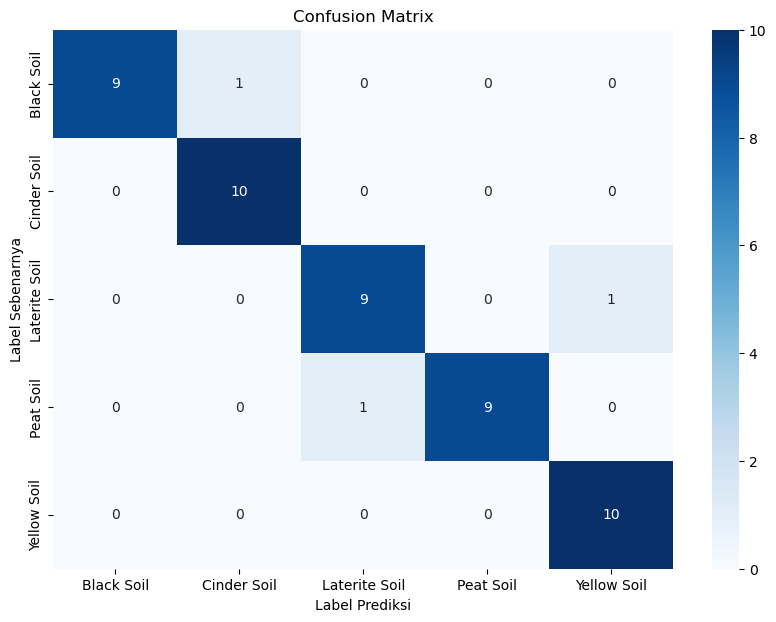

In [18]:
from sklearn.metrics import confusion_matrix

# Membuat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Menampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Label Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()